# Parsing Excel files using Snowpark

Here is a quick gist for parsing Excel file (xls), which is present in an external
stage (ex: S3) and saving the content into Snowflake table.

## Solution overview
Snowpark can read files from the stage, [doc](https://docs.snowflake.com/en/LIMITEDACCESS/snowpark-python.html#working-with-files-in-a-stage).It is also easy to read excel file using Pandas, [doc](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html).
With this mind, I wanted to see what would it take Snowpark to read the excel file, which is stored in an external stage and store the records into a Snowflake table.

**Pre-requisite**
 - the external stage should be enabled as a directory table.
 
### Code Logic
1 - Connect to Snowflake
2 - Retreive the list of excel files hosted in the external stage.
3 - Import each excel file into session
4 - Import python additional libraries into session
5 - Create the UDF, which would parse the excel file.
6 - Iterate the stage directory table, but invoking the above defined udf.
7 - If successful add the data into a staging table.

### Hurdles
Before rushing into the code, the steps was not simple as originally thought. The following are some hurdles that I had to overcome, to make the solution work.
#### Pandas extended library
For Pandas to parse XLS file, it has dependencies with the following libraries :
 - openpyxl
 - et_xmlfile
 
These are not however supplied as part of Snowflake/Conda python packaged libraries. To overcome this 
 - we upload the library in the external stage
 - at runtime, we extract the libraries into a temporary folder
 - we add the folder to system path, this allows the python classes to be imported.

#### Staging Excel file
Currently python udf, cannot read files from the stage unless it is part of the import. To overcome this, I iterate through the stage folder where the xls files are present and add each file as an import. 

**Note:** I am sure there could be some limitations on the number of files that can be imported and or total combined size of files.

---

#### Staged artifacts
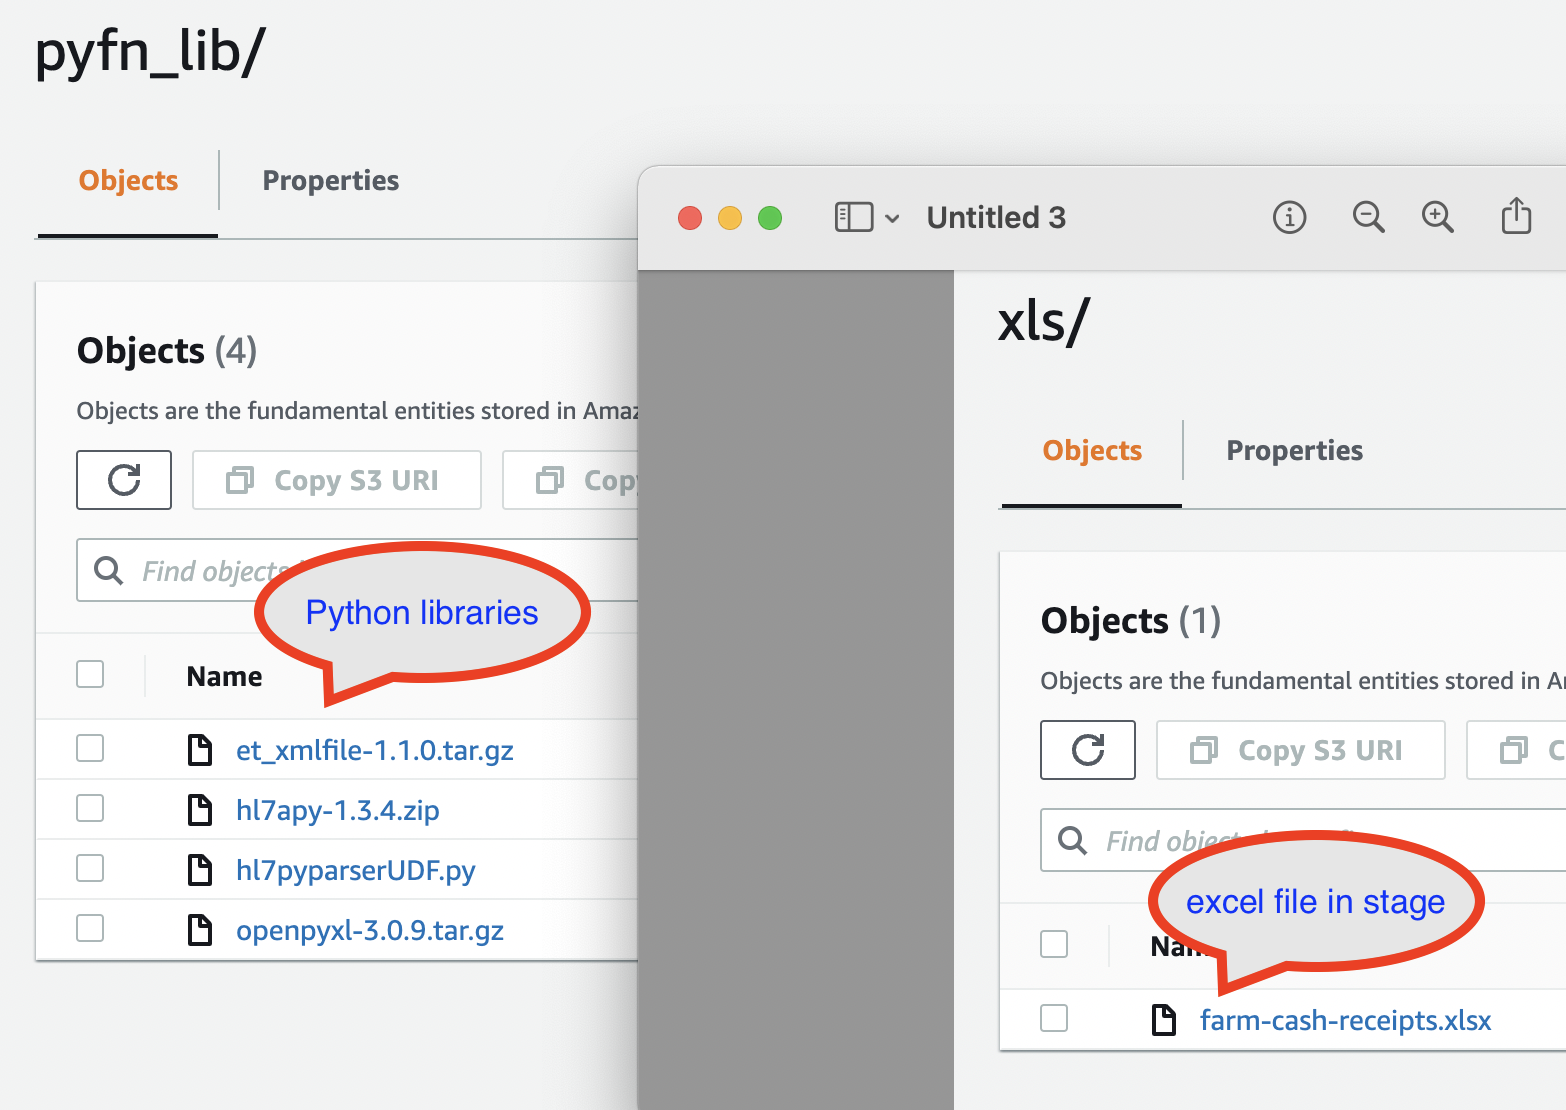

In [48]:
# Initialize the Snowpark session

import os ,json
import dotenv ,iplantuml
import pandas as pd
from snowflake.snowpark import Session

#Load the login information from env file
dotenv.load_dotenv('./sflk.env')

#Create a snowpark session
connection_parameters = {
  "account": os.getenv('DEMO_ACCOUNT'),
  "user": os.getenv('DEMO_USER'),
  "password": os.getenv('DEMO_PWD'),
  "role": "sysadmin",
  "warehouse": os.getenv('DEMO_WH'),
  "database": os.getenv('DEMO_DB'),
  "schema": os.getenv('DEMO_SCH')
}

session = Session.builder.configs(connection_parameters).create()
print(session.sql("select current_account() ,current_warehouse(), current_database(), current_schema()").collect())

[Row(CURRENT_ACCOUNT()='VA_DEMO03', CURRENT_WAREHOUSE()='LAB_WH', CURRENT_DATABASE()='HL7', CURRENT_SCHEMA()='HL7V2DEMO')]


In [49]:

# Iterate the stage 'stg_hl7data', specifically the folder 'datasets/xls' and retrieve the list of excel files
stage_name = '@stg_hl7data'

xls_files = session.sql(f'''
    select 
        concat('{stage_name}/' ,relative_path) as full_path
    from directory({stage_name} )
    where relative_path like 'datasets/xls/%';
''').collect()

# Clear any previous imports
session.clear_imports()

# Import each file into the session
for xls_fl_row in xls_files:
    xls_fl_path = f'{xls_fl_row[0]}'
    print(f'XLS : {xls_fl_path}')
    session.add_import(xls_fl_path)
    
# Add the additional required libraries needed for Pandas
libs_to_extract = ['openpyxl-3.0.9.tar.gz' ,'et_xmlfile-1.1.0.tar.gz']
for lib in libs_to_extract:
    session.add_import(f'{stage_root}/pyfn_lib/{lib}')

# List out the imports, for debugging purposes.
session.get_imports()

XLS : @stg_hl7data/datasets/xls/farm-cash-receipts.xlsx


['@stg_hl7data/datasets/xls/farm-cash-receipts.xlsx',
 '@stg_hl7data/pyfn_lib/openpyxl-3.0.9.tar.gz',
 '@stg_hl7data/pyfn_lib/et_xmlfile-1.1.0.tar.gz']

In [50]:
##
# Define the udf, which would parse the excel file
#

from snowflake.snowpark.udf import *
from snowflake.snowpark.types import Variant;
from snowflake.snowpark.functions import *
from snowflake.snowpark import *

import numpy as np
import pandas as pd
session.add_packages("numpy", "pandas")

'''
The UDF has the following paramter:
 - p_xls_path : the full path to the xls file. ex: @stg_hl7data/datasets/xls/farm-cash-receipts.xlsx
 - p_sheet_name : the sheet to parse
'''
@udf(session=session ,name="xlsparser_snowpy" ,packages=['pandas'],replace=True)
def xlsparser_snowpy(p_xls_path: str, p_sheet_name: str) -> Variant:
    import os ,sys ,json ,tarfile
    import importlib.util
    from pathlib import Path

    # Extract the third party libraries into tmp folder and dynamically import
    IMPORT_DIR = sys._xoptions["snowflake_import_directory"]
    TARGET_FOLDER = f'/tmp/xlsparser_snowpy' + str(os.getpid())
    
    libs_to_extract = ['openpyxl-3.0.9.tar.gz' ,'et_xmlfile-1.1.0.tar.gz']
    for lib in libs_to_extract:
        PACKAGE_FNAME = lib.replace('.tar.gz', '')
        TARGET_LIB_PATH = f'{TARGET_FOLDER}/{PACKAGE_FNAME}/'
        Path(f'{TARGET_LIB_PATH}').mkdir(parents=True, exist_ok=True)
        
        tf = tarfile.open(f'{IMPORT_DIR}{lib}')
        tf.extractall(f'{TARGET_FOLDER}')
    
        #Add the extracted folder to sys path
        sys.path.insert(0 ,TARGET_LIB_PATH )
    
    # an utility method to list the content of the 
    # a directory. meant for debugging needs. for ex: to find the
    # list of files in the import directory
    def list_directory(p_dir):
        fls = []
        for root, dirs, files in os.walk(p_dir):
            for file in files:
                fls.append(f'{root}{dirs}{file}')
        
        dat = {}
        dat['files'] = fls
        return json.dumps(dat)

    # The udf to handle the parsing
    def udf(p_xls_path, p_sheet_name):
        xls_full_path = f'{IMPORT_DIR}{p_xls_path}'
        xls_df = pd.read_excel(xls_full_path ,sheet_name=p_sheet_name)
        parsed = xls_df.to_json(orient="records")
        return parsed
    
    # -------------- MAIN ---------------
    return udf(p_xls_path, p_sheet_name)

In [57]:
df = session.sql('''
select 
    parse_json(
        xlsparser_snowpy('farm-cash-receipts.xlsx', 'Data') 
    ) as xls_parsed
''')
df.show(5)


------------------------------------------------------
|"XLS_PARSED"                                        |
------------------------------------------------------
|[                                                   |
|  {                                                 |
|    "Alberta": 4215000,                             |
|    "BritishColumbia": 189000,                      |
|    "Canada": 22302000,                             |
|    "FarmCashReceiptType": "Total receipts from...  |
|    "Manitoba": 1900000,                            |
|    "NewBrunswick": 139000,                         |
|    "NewfoundlandAndLabrador": 0,                   |
|    "NovaScotia": 70000,                            |
|    "Ontario": 5178000,                             |
|    "PrinceEdwardIsland": 245000,                   |
|    "Quebec": 6029000,                              |
|    "Saskatchewan": 4337000,                        |
|    "When": 36633600000                             |
|  },     

In [79]:
df = session.sql('''
select 
    relative_path,
    
    -- the absolute path
    concat('@stg_hl7data/' ,relative_path) as full_path,
    
    -- we need to get the xls file name from the path, we achieve this by
    -- spliting the relative path into array and taking the last component 
    -- which is the file name
    split(relative_path, '/') as fl_splits,
    get(fl_splits, 
        array_size(fl_splits)-1)::varchar as xls_fl
        
    -- involve the udf to parse the xls file
    ,parse_json(
        xlsparser_snowpy('farm-cash-receipts.xlsx', 'Data') 
    ) as xls_parsed
from directory( @stg_hl7data )
where relative_path like 'datasets/xls/%'
''')
df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RELATIVE_PATH"                       |"FULL_PATH"                                        |"FL_SPLITS"                  |"XLS_FL"                 |"XLS_PARSED"                                        |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|datasets/xls/farm-cash-receipts.xlsx  |@stg_hl7data/datasets/xls/farm-cash-receipts.xlsx  |[                            |farm-cash-receipts.xlsx  |[                                                   |
|                                      |                                                   |  "datasets",                |                         |  {                                         

In [ ]:
# store as table
df.write.mode("overwrite").save_as_table("xls_data_from_stage")

df_tbl = session.table("xls_data_from_stage")

display(df_tbl.select('XLS_PARSED').to_pandas())

,XLS_PARSED
0,"[\n {\n ""Alberta"": 4215000,\n ""BritishC..."


#### Table in Snowflake

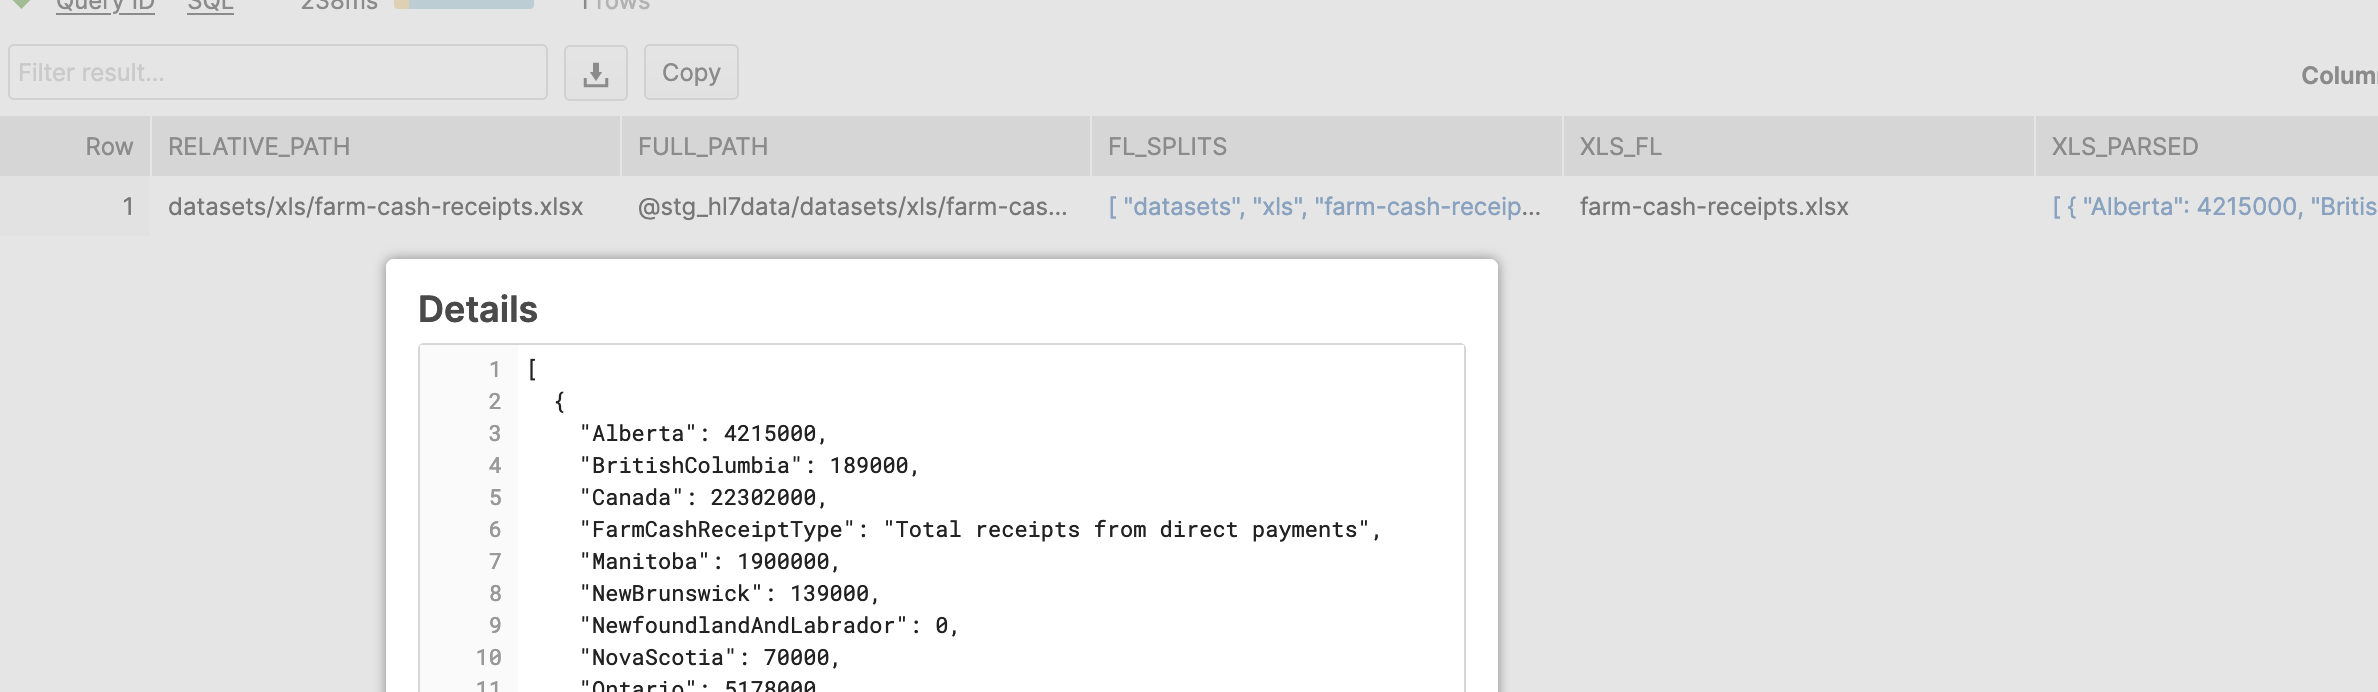# New Section

In [30]:
#close the snowpark session
session.close()

##### References
- Datasets : [Open Canada / Farm Cash Receipts](https://open.canada.ca/data/en/dataset/6acc9dd9-97fe-4930-a562-f65660ca42d1)